In [2]:
from setup_libs import *
from plot_clas import *
import warnings
warnings.filterwarnings('ignore')

# Boosting

## Sample weighting
До этого момента мы всегда считали объекты выборки равнозначными (равномерными). Но на практике (и во многих алгоритмах) используется понятие веса объекта. По сути, мы просим алгоритм лучше подстраиваться под одни объекты и хуже под другие.

Пусть есть выборка $(X,y)_N$ и веса объектов $W = \{w_1, \ldots, w_N\}$. 

Тогда стандартные функционалы минимизации для бинарной классификации и регрессии перепишутся следующим образом:

$$1 - Accuracy = Q_{clf} = \frac{\sum_{i=1}^{N}w_i\mathcal{I}(y_i \neq a(x_i))}{\sum_{i=1}^{N}w_i}$$

$$MSE = Q_{reg} = \frac{\sum_{i=1}^{N}w_i(y_i - a(x_i))^2}{\sum_{i=1}^{N}w_i}$$

Очевидно, что $a(x)$ также будет зависеть внутри от $W$, чтобы минимизировать функционал, который теперь зависит от $W$


In [3]:
y_real = np.array([ 0, 0, 1, 0])
y_pred = np.array([ 0, 1, 1, 0])
W = np.array([ 2, 10, 2, 2])
MSE(y_real,y_pred, sample_weight=W), MSE(y_real,y_pred)

(0.625, 0.25)

In [4]:
y_real = np.array([ 0, 0, 1, 0])
y_pred = np.array([ 0, 1, 1, 0])
W = np.array([ 2, 10, 2, 2])
accuracy_score(y_real,y_pred, sample_weight=W), accuracy_score(y_real,y_pred)

(0.375, 0.75)

# Идея Бустинга: комбинация **зависимых** алгоритмов.

1. Обучаем алгоритм $a$ на выборке с равномерными весами
2. Считаем ошибку алгоритма
3. **Увеличиваем** веса объектов, на которых ошиблись
4. Обучаем новый $a_1$ алгоритм на **этой же** выборке с **новыми весами** 
  * Новый алгоритм будет лучше работать на объектах с увеличинными весами
5. Переобозначаем $a = c_1a + c_2a_1$
6. Возвращаемся **к шагу 3**, пока не будем удовлетворены точностью
7. Возвращаем первый алгоритм

### Пример классификации

Пусть базовые алгоритмы – всего лишь "пеньки", то есть деревья решений глубины 1.

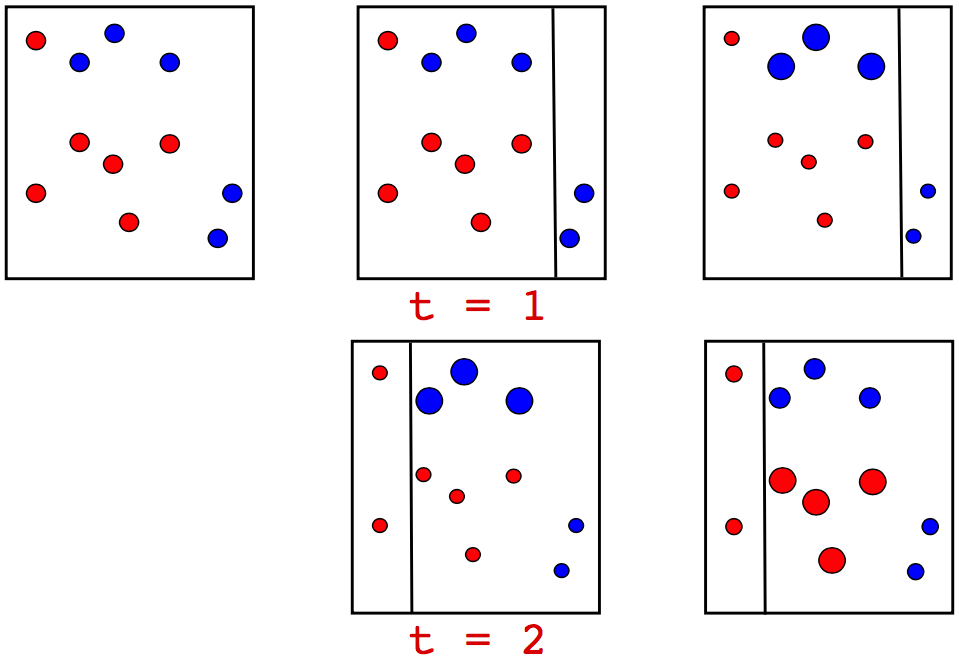

In [5]:
Image('images/adaboost_toy_step1.png', width=400)

1. Итерация $t=1$: обучили на равномерных весах, увеличили веса у ошибочных(синие кружки увеличиваются в размере).
2. Итерация $t=2$: обучили на новых весах, увеличили веса у ошибочных (красные кружки).

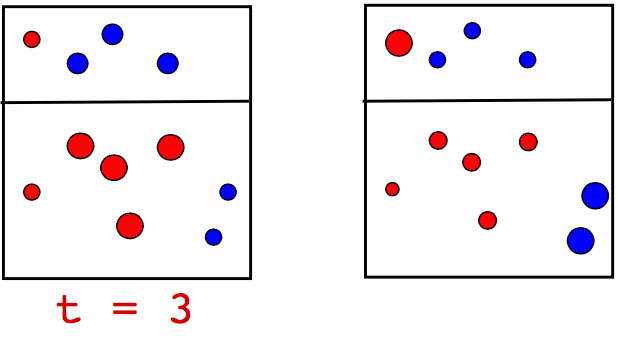

In [6]:
Image('images/adaboost_toy_step2.png', width=300)

3. Итерация $t=3$: снова обучили, увеличили веса у ошибочных(тут есть и синие и красные).

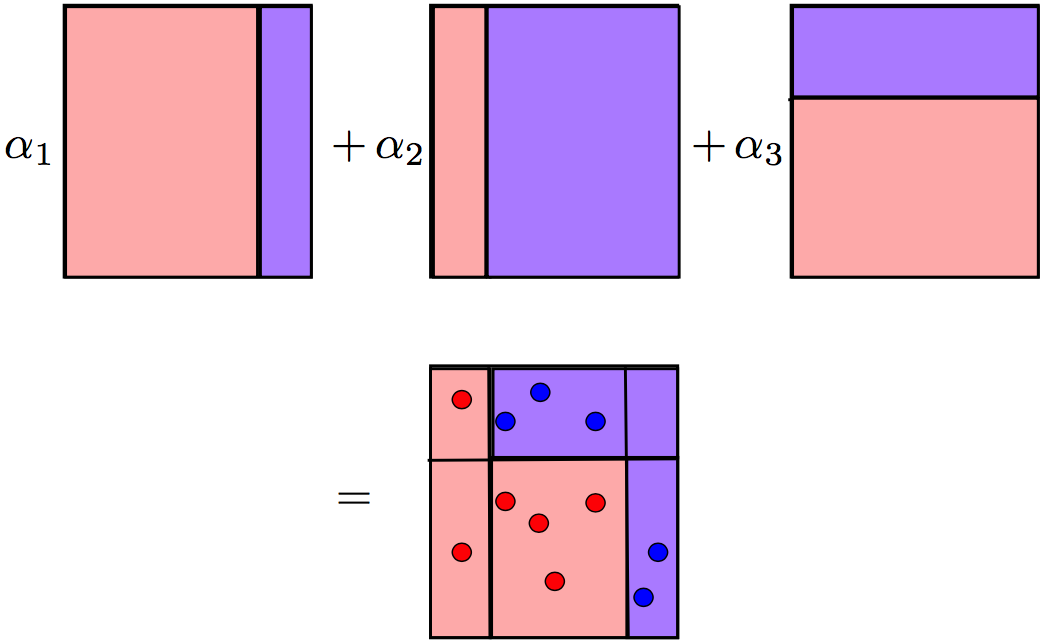

In [7]:
Image('images/adaboost_toy_step3.png', width=400)

4. В конце создаем линейную комбинацию из алгоритомов. Получаем итоговый алгоритм.

Основные проблемы 2:
* Как увеличивать веса
* Как коэффициенты ставить у линейной комбинации

Разные алгоритмы бустинга по-разному решают данную проблему

# Формальная постановка Бустинга для классификации

### Постановка задачи
* $(X, y)_{N}$ - тренировочная выборка длины $N$, где $y_i \in \{-1, 1\}$ ($-1$ вместо $0$ - удобнее для алгоритма)
* $Q(a, X, y)$ - количество ошибок (функционал, который будем минимизировать)

$$Q(a, X, y) = \sum_{i=1}^{N}\mathcal{I}(y_i \neq a(x)) = \sum_{i=1}^{N}[y_ia(x_i) < 0] =\sum_{i=1}^{N}[M < 0]$$

$[M < 0]$ - пороговая функция, которая равная $1$, если условие выполняется и $0$, если не выполняется


Будем искать решение в виде
 $$a(x) = \mbox{sign}\Big(\sum_{t = 1}^T \alpha_t b_t(x)\Big)$$

* $b_1, \ldots, b_T\in \mathcal{B}$ - пространство базовых алгоритмов **классификации**, из которого будем брать алгоритмы (например деревья решений)
* $sign(x)$ - функция знака: если $x > 0$, то $sign(x) = 1$, если $x < 0$, то $sign(x) = -1$, иначе $sign(x) = 0$

По основной идее мы собираемся на каждой итерации $m$ обучать новый алгоритм с неполным функционалом минимизации:

$$Q_T(X, y) = \sum_{i=1}^{N}\Big[y_i\sum_{t = 1}^T \alpha_t b_t(x) < 0\Big]$$

В идеале алгоритм требует переоптимизации всех алгоритмов $b_1, \ldots, b_T$. Но мы воспользуемся эвристикой и **зафиксируем** уже обученные алгоритмы и изменяем только текущий алгоритм $b_T$

$$Q_T(X, y) = \sum_{i=1}^{N}\Big[y_i(C(x_i) + \alpha_T b_T(x_i)) < 0\Big]$$ 

# Adaboost

Нам не ясно что делать с нынешним функционалом. У пороговой функции нельзя взять производную. Основная задача теперь - как-то гладко **аппроксимировать** функцию потерь, чтобы можно было взять **производные**. Так как мы хотим уменьшать $Q$, нам нужно заменить его на такую функцию $\tilde{Q}$, которая во всех точках больше пороговой функции.

Для алгоритма AdaBoost (первого алгоритма бустинга) такой функцией выступает $e^{-M}$. 

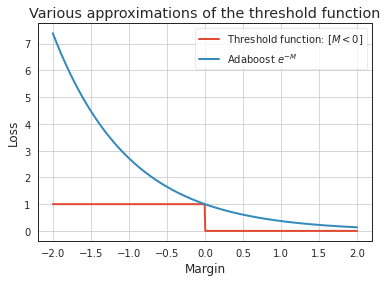

In [8]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(6,4))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[M < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='Adaboost $e^{-M}$')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')
plt.xlabel('Margin')
plt.ylabel('Loss');
plt.grid()

Она во всех точках больше пороговой функции, поэтому новый функционал минимизации будет не меньше исходного

$$Q_T \leq \tilde{Q}_T = \sum_{i=1}^{N}exp\Big(-y_i(C(x_i) + \alpha_Tb_T(x_i))\Big)=$$$$=\sum_{i=1}^{N}\underbrace{exp\Big(-y_i\sum_{t=1}^{T-1}\alpha_tb_t(x_i)\Big)} exp\Big(-\alpha_Ty_ib_T(x_i)\Big) = \sum_{i=1}^{N}w_i^{(T-1)} exp\Big(-\alpha_Ty_ib_T(x_i)\Big)$$

Получили, что оптимизация функционала $\tilde{Q}_T$ эквивалентна оптимизации функционала $\tilde{Q}_{1}$, с **измененными весами**. Ведь для $\tilde{Q}_{1}$ мы берем равномерные веса: $w_i^{(0)} = \frac{1}{N}$.

$$w_i^{(T)} = w_i^{(T-1)}exp\Big(-\alpha_Ty_ib_T(x_i)\Big)$$

Ну и нужно не забыть нормировать, на алгоритм (в рамках одной оптимизации) это не влияет на качество, зато предотвращает от переполнения чисел.

$$\tilde{w}_i^{(T)} = \frac{w_i^{(T)}}{\sum_{i=1}^{N}w_i^{(T)}}$$

## Теорема Freund Schapire

Осталось одна проблема: какие выбрать $\alpha_t$ для достижения наилучшей композиции в нашем процессе?

На этот вопрос умеет отвечать теорема Freund-Schapire:

Введем 2 обозначения:
* $P(b, W) = \sum_{i=1}^{N}w_i[b(x_i) = y_i]$ - взвешанная доля верных ответов алгоритма $b$ на данных $(X, y)$
* $N(b, W) = \sum_{i=1}^{N}w_i[b(x_i) \neq y_i]$ - взвешанное доля ошибок алгоритма $b$ на данных $(X, y)$

Пусть для любого нормированного вектора весов $W$ существует алгоритм $b \in \mathcal{B}$, классифицирующий выборку хотя бы немного лучше, чем наугад: $P(b, W) >N(b, W)$. 

Тогда минимум функционала $\tilde{Q}_T$ достигается при

$$b_T = argmin_{b\in \mathcal{B}}N(b, W)$$

$$\alpha_T = \frac{1}{2}\ln\frac{P(b_T, W)}{N(b_T, W)}$$

Доказательство данной теоремы можно прочитать [здесь](http://www.machinelearning.ru/wiki/images/archive/c/cd/20140304184935%21Voron-ML-Compositions-slides.pdf) на странице 10


# Алгоритм AdaBoost

Теперь у нас есть все, чтобы собрать наш алгоритм

- Инициализировать веса объектов $w_i^{(0)} = \frac{1}{N}, i = 1, \dots, N$.
- Для всех $t = 1, \dots, T$
    * Обучить базовый алгоритм $b_t$ на **взвешанных объектах**, пусть $\epsilon_t$ – его ошибка на обучающей выборке.
    $$\epsilon_t = Q(b_t, X, y) = \sum_{i=1}^{N}w_i^{(t-1)}[y_i \neq b_t(x)]$$
        * Если $\epsilon \geq 0.5$, то не имеет смысла дальше продолжать работать с данным семейством решений (оно работает хуже рандома)
    * Коэффициент $$\alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t} > 0$$
    * Обновить веса объектов: $$w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)},~~ i = 1, \dots, N$$
        * Веса объектов, которые неверно классифицировались - увеличиваются, другие - уменьшаются 
        $$\begin{cases}
                e^{-\alpha_t y_i b_t(x_i)} < 1~~~~\textrm{если}~~ y_i = b_t(x_i) \\ 
                e^{-\alpha_t y_i b_t(x_i)} > 1~~~~\textrm{если}~~ y_i \neq b_t(x_i) 
            \end{cases}$$
    * Нормировать веса объектов: $w_i^{(t)} = \frac{w_i^{(t)}}{\sum_{j = 1}^k w_j^{(t)}}, i = 1, \dots, N$.
- Вернуть $a = \sum_t^{T}\alpha_tb_t$

Таким образом, вновь добавляемый алгоритм обучается путём минимизации взвешенной частоты ошибок на обучающей выборке, а не стандартного функционала, равного частоте ошибок. 

Вес объекта увеличивается в $e^{\alpha_t}$ раз, когда $b_t$ допускает на нём ошибку, и уменьшается во столько же раз, когда $b_t$ правильно классифицирует этот объект. Таким образом, непосредственно перед настройкой базового алгоритма наибольший вес накапливается у тех объектов, которые чаще оказывались трудными для классификации предыдущими алгоритмами.

## А теперь примеры

Стоит заметить, что встроенный алгоритм не совсем AdaBoost, a SAMME. Идея та же, но есть пара хитростей, которые улучшают работу алгоритма. Его описание можно прочитать [здесь](https://web.stanford.edu/~hastie/Papers/samme.pdf)

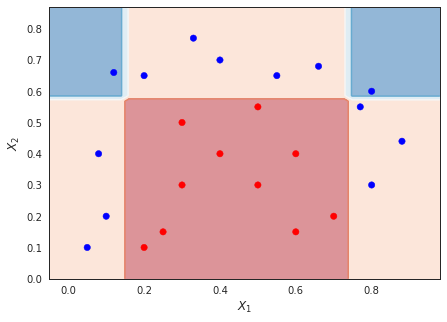

Accuracy: 1.0


In [9]:
from sklearn.ensemble import AdaBoostClassifier
#Toy Dataset
x1 = np.array([.1,.2,.4,.8, .8, .05,.08,.12,.33,.55,.66,.77,.88,.2,.3,.4,.5,.6,.25,.3,.5,.7,.6])
x2 = np.array([.2,.65,.7,.6, .3,.1,.4,.66,.77,.65,.68,.55,.44,.1,.3,.4,.3,.15,.15,.5,.55,.2,.4])
y = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
X = np.vstack((x1,x2)).T

boost = AdaBoostClassifier(base_estimator = DTC(max_depth = 1),
                           algorithm="SAMME",
                           n_estimators=10)
boost.fit(X,y)
plt.figure(figsize=(7,5))
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

print('Accuracy: {}'.format(boost.score(X,y)))

Деревья строят ровные линии вдоль осей координат, из комбинации деревьев получаем сетку, где есть объекты, которые точно попадают в определенный класс, сомнительные объекты и точно в другой класс

## Дополнительно

Одной действительно значимой эвристикой для AdaBoost являются **неуверенные** базовые алгоритмы.

Пусть у нас базовый алгоритм помимо $\{-1, 1\}$ может возвращать еще и $0$, если он не достаточно уверен в своем ответе. (Например если вероятность ответов не сильно отличается от $50\%$)

В этом случае алгоритм начинает работать существенно лучше.

Для этого случая аналогично доказаны теорема Freund Schapire.
Только минимум функционала $\tilde{Q}_T$ достигается при

$$b_T = argmin_{b\in \mathcal{B}}\sqrt{N(b,W)} - \sqrt{P(b, W)}$$

$$\alpha_T = \frac{1}{2}\ln\frac{P(b_T, W)}{N(b_T, W)}$$

Доказательство данной теоремы можно прочитать [здесь](http://www.machinelearning.ru/wiki/images/archive/c/cd/20140304184935%21Voron-ML-Compositions-slides.pdf) на странице 10


# Пример AdaBoost

In [4]:
from random import gauss
num_samples = 100
theta = np.linspace(0, 2*np.pi, num_samples)

r1 = 1
r2 = 1.5

rng = np.random.RandomState(1)

circle = np.hstack([np.cos(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8), 
                    np.sin(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8)])
lil = r1 * circle
big = r2 * circle
X = np.vstack([lil, big])
y = np.hstack([np.zeros(num_samples), np.ones(num_samples)])



## Посмотрим на результаты при разных количествах эстиматоров. За базовый эстиматор возьмем дерево решений для классификации.

CPU times: user 5.73 s, sys: 80.7 ms, total: 5.81 s
Wall time: 5.81 s


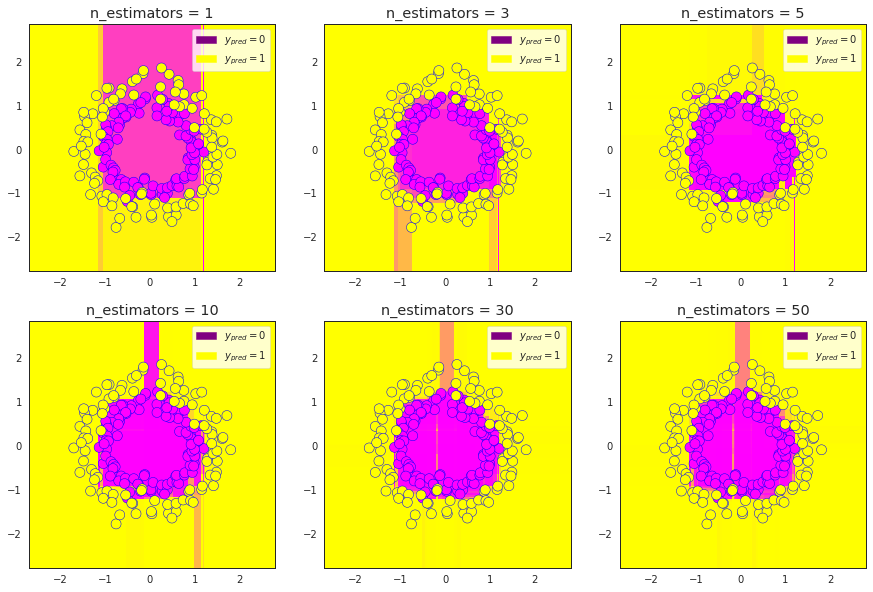

In [5]:
%%time
fig = plt.figure(figsize = (15,10))
n_est = [1,3,5,10,30,50]
for m in range(0, 6):
    fig.add_subplot(2,3,m+1)
    abc = AdaBoostClassifier(base_estimator=DTC(max_depth=3),
                             n_estimators=n_est[m],
                             random_state=42).fit(X, y) # обучаем модель
    plot_model(X,y,abc,
               title='n_estimators = {}'.format(n_est[m]),
               proba=True)

# Источники и полезные ссылки
* [Визуализация](https://xavierbourretsicotte.github.io/AdaBoost.html)
* [Implementation](https://github.com/jaimeps/adaboost-implementation)
* [Sample weights](https://stackoverflow.com/questions/34389624/what-does-sample-weight-do-to-the-way-a-decisiontreeclassifier-works-in-skle)
* [Статья](http://www.robots.ox.ac.uk/~az/lectures/cv/adaboost_matas.pdf)
- [Лекция](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации